# Weird confidence intervals



In [3]:
import sys
import os
import time
import numpy as np
np.random.seed(42)

import json

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr')

from refl1d.names import *
from refl1d import errors

from bumps.fitters import fit


In [12]:
data_file = os.path.join(git_dir, 'data', 'REFL_207282_combined_data_auto.txt')


Q, R, dR, dQ = np.loadtxt(data_file).T

# SNS data is FWHM
dQ_std = dQ/2.35
probe = QProbe(Q, dQ_std, data=(R, dR))

# Materials ####################################################################
Si = SLD(name='Si', rho=2.07, irho=0.0)
THF = SLD(name='THF', rho=6.13, irho=0.0)
siox = SLD(name='siox', rho=3.2, irho=0.0)
Ti = SLD(name='Ti', rho=-2.0, irho=0.0)
Cu = SLD(name='Cu', rho=6.446, irho=0.0)
material = SLD(name='material', rho=2.685, irho=0.1)
SEI = SLD(name='SEI', rho=3.8, irho=0.1)


# Film definition ##############################################################
sample = (  THF(0, 54.16) | SEI(158.3, 13.1) | material(54.42, 9.74) | Cu(560.6, 15.24) | Ti(49.9, 11.1) | siox(18.83, 2.92) | Si )

sample['Ti'].thickness.range(10.0, 100.0)
sample['Ti'].interface.range(1.0, 15.0)
sample['Cu'].thickness.range(10.0, 800.0)
sample['Cu'].interface.range(11.0, 22.0)
sample['material'].thickness.range(10.0, 200.0)
sample['material'].material.rho.range(1.0, 8.0)
sample['material'].interface.range(1.0, 33.0)
sample['SEI'].thickness.range(100.0, 350.0)
sample['SEI'].material.rho.range(0.0, 7.0)
sample['SEI'].interface.range(1.0, 55.0)



probe.intensity=Parameter(value=1.1,name='normalization')
probe.background.range(0.0, 1e-05)
sample['THF'].interface.range(1.0, 111.0)

################################################################################

expt = Experiment(probe=probe, sample=sample)
problem = FitProblem(expt)

In [7]:
# Adapted from bumps
"""
  Show an uncertainty band for an SLD profile.
  This currently works for inverted geometry and fixed substrate roughness, as it aligns
  the profiles to that point before doing the statistics.
"""
def get_sld_contour(problem, state, cl=90, npoints=1000, trim=1000, portion=1, index=1, align='auto'):
    points, _logp = state.sample(portion=portion)
    #points = points[-trim:-1]
    points = points[:trim]
    original = problem.getp()
    _profiles, slabs, Q, residuals = errors.calc_errors(problem, points)
    problem.setp(original)
    
    profiles = errors.align_profiles(_profiles, slabs, align)

    # Group 1 is rho
    # Group 2 is irho
    # Group 3 is rhoM
    contours = []
    for model, group in profiles.items():
        ## Find limits of all profiles
        z = np.hstack([line[0] for line in group])
        zp = np.linspace(np.min(z), np.max(z), npoints)

        # Columns are z, best, low, high
        data, cols = errors._build_profile_matrix(group, index, zp, [cl])
        contours.append(data)
    return contours

def fit_and_plot():
    results = fit(problem, method='dream', samples=1000, burn=1000, verbose=None)

    q, r = expt.reflectivity()

    fig, axs = plt.subplots(2,1, dpi=100, figsize=(6,8), sharex=False)
    ax = plt.subplot(2, 1, 1)
    plt.errorbar(Q, R, yerr=dR, label='data', linestyle='', marker='.')
    plt.plot(q, r, color='gray', label='prediction')

    plt.gca().legend()
    plt.xlabel('q [$1/\AA$]')
    plt.ylabel('R(q)')
    plt.xscale('log')
    plt.yscale('log')

    z, best, low, high = get_sld_contour(problem, results.state, cl=95, align=-1)[0]

    ax = plt.subplot(2, 1, 2)
    _z = z[-1]-z+0
    plt.plot(_z, best, markersize=4, label='best', linewidth=2,)
    plt.fill_between(_z, low, high, alpha=0.2, color=plt.gca().lines[-1].get_color())

# steps: 9, # draws: 1080
# steps: 9, # draws: 1080


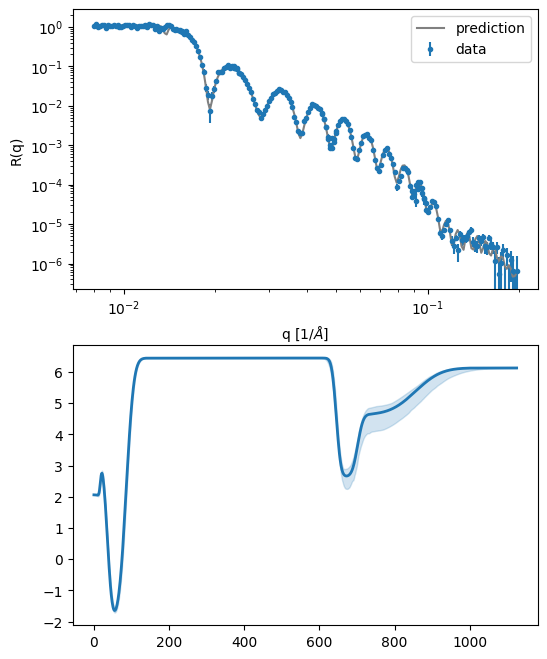

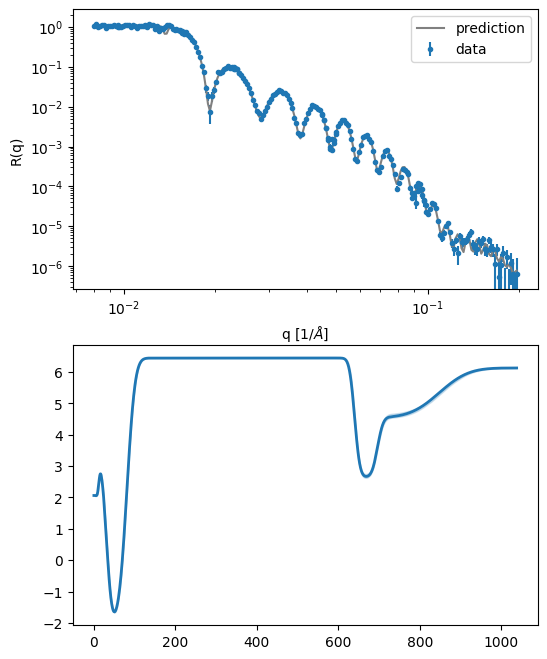

In [13]:
fit_and_plot()
fit_and_plot()

